In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [7]:

from dataclasses import replace
import itertools
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, cdist
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

from src.analysis import coherence
from src.analysis.state_space import prepare_state_trajectory, StateSpaceAnalysisSpec
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, compute_embeddings, load_or_compute_embeddings

In [8]:
model_dir = "outputs/models/w2v2_6_8/phoneme"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"
output_dir = "."

state_space_spec_path = "out/state_space_specs/all_phonemes_by_identity.pkl"

metric = "cosine"

In [9]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [10]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [11]:
with open(state_space_spec_path, "rb") as f:
    state_space_spec: StateSpaceAnalysisSpec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [12]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [13]:
# Retain only phonemes with N or more instances
retain_n = 3
drop_idxs = [idx for idx, target_frames in enumerate(state_space_spec.target_frame_spans)
               if len(target_frames) < retain_n]
state_space_spec = state_space_spec.drop_labels(drop_idxs)

In [14]:
trajectory = prepare_state_trajectory(model_representations, state_space_spec, pad=np.nan)

In [15]:
lengths = [np.isnan(traj_i[:, :, 0]).argmax(axis=1) for traj_i in trajectory]

In [16]:
len(trajectory)

39

## Estimate within-phoneme distance

In [17]:
within_distance, within_distance_offset = \
    coherence.estimate_within_distance(trajectory, lengths, state_space_spec, metric=metric)

  0%|          | 0/39 [00:00<?, ?it/s]

<Axes: >

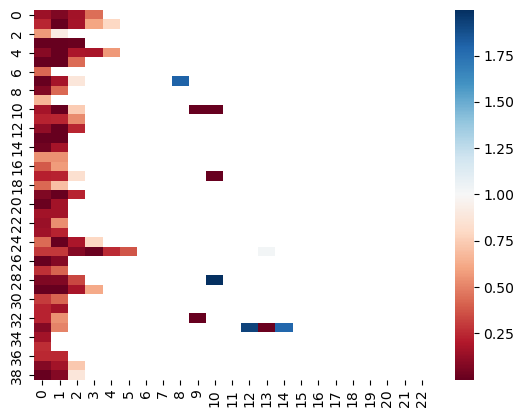

In [18]:
sns.heatmap(within_distance, center=1, cmap="RdBu")

In [19]:
within_distance_df = pd.DataFrame(within_distance, index=pd.Index(state_space_spec.labels, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

In [20]:
within_distance_offset_df = pd.DataFrame(within_distance_offset, index=pd.Index(state_space_spec.labels, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

## Estimate between-phoneme distance

In [21]:
between_distance, between_distance_offset = \
    coherence.estimate_between_distance(trajectory, lengths, state_space_spec, metric=metric)

Reducing num_samples to 38 given limited data


  0%|          | 0/39 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [22]:
between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_761023/473681666.py:1: RuntimeWarning: Mean of empty slice
  between_distances_df = pd.DataFrame(np.nanmean(between_distance, axis=-1),


In [23]:
between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),
                                    index=pd.Index(state_space_spec.labels, name="phoneme")) \
    .reset_index() \
    .melt(id_vars=["phoneme"], var_name="frame", value_name="distance")

/tmp/ipykernel_761023/2876845580.py:1: RuntimeWarning: Mean of empty slice
  between_distances_offset_df = pd.DataFrame(np.nanmean(between_distance_offset, axis=-1),


## Together

In [24]:
merged_df = pd.concat([within_distance_df.assign(type="within"), between_distances_df.assign(type="between")])
merged_df.to_csv(Path(output_dir) / "distances.csv", index=False)
merged_df

,phoneme,frame,distance,type
0,AA,0,0.143880,within
1,AE,0,0.240009,within
2,AH,0,0.563238,within
3,AO,0,0.006305,within
4,AW,0,0.090351,within
...,...,...,...,...
892,V,22,NaN,between
893,W,22,NaN,between
894,Y,22,NaN,between
895,Z,22,NaN,between


Text(0, 0.5, 'Cosine distance')

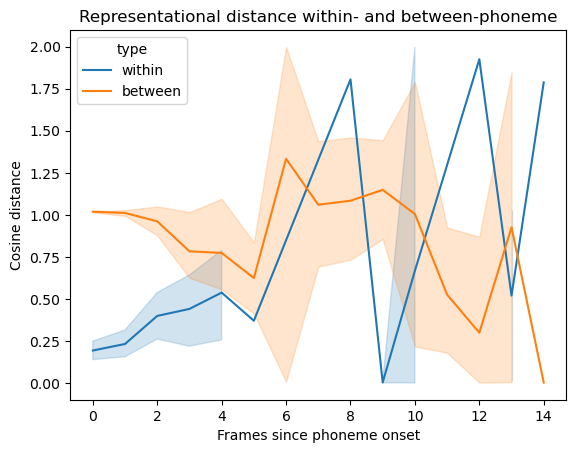

In [25]:
ax = sns.lineplot(data=merged_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-phoneme")
ax.set_xlabel("Frames since phoneme onset")
ax.set_ylabel(f"{metric.capitalize()} distance")

In [26]:
merged_offset_df = pd.concat([within_distance_offset_df.assign(type="within"), between_distances_offset_df.assign(type="between")])
merged_offset_df.to_csv(Path(output_dir) / "distances_aligned_offset.csv", index=False)
merged_offset_df

,phoneme,frame,distance,type
0,AA,0,NaN,within
1,AE,0,NaN,within
2,AH,0,NaN,within
3,AO,0,NaN,within
4,AW,0,NaN,within
...,...,...,...,...
892,V,22,NaN,between
893,W,22,NaN,between
894,Y,22,NaN,between
895,Z,22,NaN,between


Text(0, 0.5, 'Cosine distance')

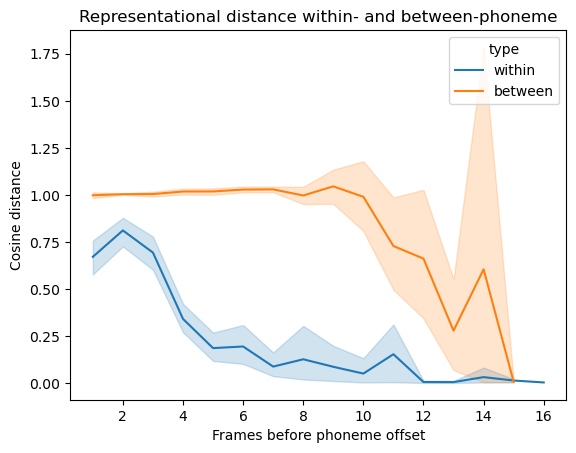

In [27]:
ax = sns.lineplot(data=merged_offset_df.dropna(), x="frame", y="distance", hue="type")
ax.set_title("Representational distance within- and between-phoneme")
ax.set_xlabel("Frames before phoneme offset")
ax.set_ylabel(f"{metric.capitalize()} distance")

## Block by phoneme categories

In [28]:
categorization = {
    "consonant": "B CH D DH F G HH JH K L M N NG P R S SH T TH V W Y Z ZH".split(" "),
    "vowel": "AA AE AH AO AW AY EH ER EY IH IY OW OY UH UW".split(" "),
}

In [30]:
num_frames = trajectory[0].shape[1]

for phoneme_list in categorization.values():
    for phoneme in phoneme_list:
        assert phoneme in state_space_spec.labels, f"Phoneme {phoneme} missing from state space spec"

# Prepare balanced sample of representations for each phoneme in each category
num_instances = min(len(state_space_spec.target_frame_spans[i]) for i in range(len(state_space_spec.labels)))
# HACK this is just to make the number of instnaces different than the number of frames, to make sure I don't make debuggnig mistakes
num_instances -= 1

all_phonemes = sorted(set(itertools.chain.from_iterable(categorization.values())))
phoneme_representations, phoneme_representation_lengths = {}, {}
for phoneme in all_phonemes:
    sample_instance_idxs = np.random.choice(len(state_space_spec.target_frame_spans[state_space_spec.labels.index(phoneme)]),
                                            num_instances, replace=False)
    phoneme_representations[phoneme] = np.array([trajectory[state_space_spec.labels.index(phoneme)][idx]
                                                 for idx in sample_instance_idxs])
    phoneme_representation_lengths[phoneme] = lengths[state_space_spec.labels.index(phoneme)][sample_instance_idxs]

# Compute between-phoneme distances
distances = np.zeros((len(all_phonemes), len(all_phonemes), trajectory[0].shape[1]))
for p1, p2 in itertools.product(list(range(len(all_phonemes))), repeat=2):
    for k in range(num_frames):
        mask1 = phoneme_representation_lengths[all_phonemes[p1]] >= k
        mask2 = phoneme_representation_lengths[all_phonemes[p2]] >= k
        if mask1.sum() == 0 or mask2.sum() == 0:
            break

        distances[p1, p2, k] = coherence.get_mean_distance(phoneme_representations[all_phonemes[p1]][mask1, k, :],
                                                           phoneme_representations[all_phonemes[p2]][mask2, k, :], metric=metric)
        
# Compute between- and within-category distance trajectory
within_distances, between_distances, within_comparisons, between_comparisons = {}, {}, {}, {}
for category, phonemes in categorization.items():
    within_comparisons[category] = list(itertools.combinations(phonemes, 2))
    between_comparisons[category] = [(p1, p2) for p1, p2 in itertools.product(phonemes, all_phonemes) if p1 in phonemes and p2 not in phonemes]
    within_distances[category] = np.stack([distances[all_phonemes.index(p1), all_phonemes.index(p2)] for p1, p2 in within_comparisons[category]], axis=0)
    between_distances[category] = np.stack([distances[all_phonemes.index(p1), all_phonemes.index(p2)] for p1, p2 in between_comparisons[category]], axis=0)

/userdata/jgauthier/projects/ideal-word-representations/src/analysis/coherence.py:13: RuntimeWarning: Mean of empty slice.
  return distances[distances != 0].mean()
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
all_within_distances = pd.concat(
    {category: pd.DataFrame(within_distances[category], index=pd.Index(within_comparisons[category], name=("p1", "p2")), columns=pd.Index(range(num_frames), name="frame")) \
                .melt(ignore_index=False, var_name="frame", value_name="distance")
     for category in categorization},
    names=["category"]
)

all_between_distances = pd.concat(
    {category: pd.DataFrame(between_distances[category], index=pd.Index(between_comparisons[category], name=("p1", "p2")), columns=pd.Index(range(num_frames), name="frame")) \
                .melt(ignore_index=False, var_name="frame", value_name="distance")
     for category in categorization},
    names=["category"]
)

In [32]:
all_distances = pd.concat([all_within_distances, all_between_distances], keys=["within", "between"], names=["type"])
all_distances.to_csv(Path(output_dir) / "grouped_distances.csv")
all_distances

frame  distance
type    category  p1 p2                 
within  consonant B  CH      0  0.201735
                     D       0  0.276169
                     DH      0  1.369328
                     F       0  0.192314
                     G       0  0.244108
...                        ...       ...
between vowel     UW V      22  0.000000
                     W      22  0.000000
                     Y      22  0.000000
                     Z      22  0.000000
                     ZH     22  0.000000

[25323 rows x 2 columns]

<Axes: xlabel='frame', ylabel='distance'>

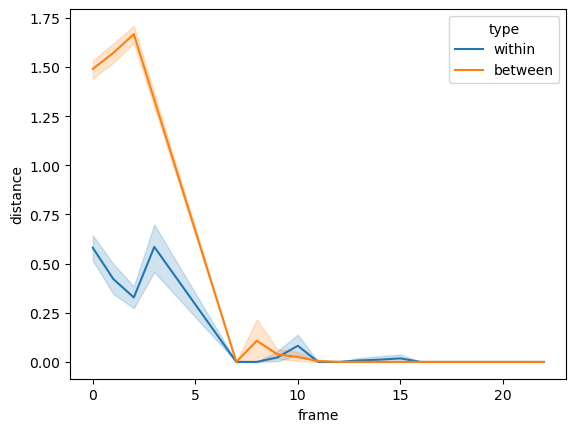

In [33]:
sns.lineplot(data=all_distances.reset_index(), x="frame", y="distance", hue="type")

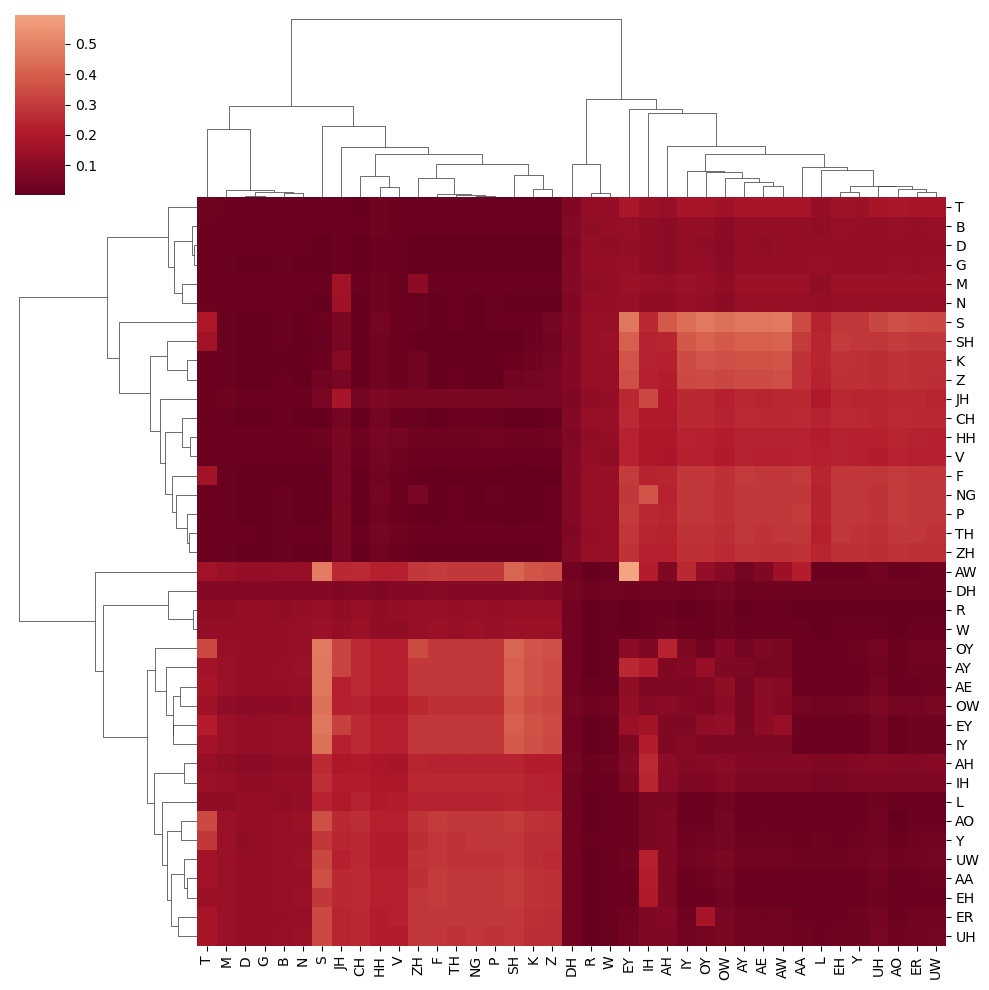

In [34]:
sns.clustermap(pd.DataFrame(np.nanmean(distances, -1), index=all_phonemes, columns=all_phonemes),
               center=1, cmap="RdBu")